## Web APIs for data 

files needed = None! (It's all coming from the cloud.)

We have been loading data from files using `pd.read_csv()` and `pd.read_excel()`. Another way to input data into pandas is by directly downloading data from a web server through an *application programming interface* or api. 

The [wikipedia page](https://en.wikipedia.org/wiki/Web_API) isn't that insightful, but an api is a way to directly query a webserver and (in our case) ask for data. An api provides several advantages:

1. You only download the data you need
2. You do not need to distribute data files with your code
3. You have access to the 'freshest data'

There are downsides to using apis, too.

1. You need to be online to retrieve the data
2. The group hosting the data may 'revise' the data, making it difficult to replicate your results
3. The api may change, breaking your code

On the whole, I find apis very convenient and useful. Let's dig in. We will cover:

* Using pandas datareader
* Building our own queries and using the requests package

### The packages
The package `pandas_datareader` collects functions that interact with several popular data sources to access their apis. These include:

* ~~Google finance~~
* Morningstar
* St. Louis Fed's FRED
* World Bank
* Stooq 
* Eurostat
* Quandl (Nasdaq)


### API keys

Many data providers do not want some anonymous account connecting to the api and downloading data. These providers ask you to create an account and you are given an *api key* that you pass along with your request. Sometimes the keys are free, sometimes they are not.

In this notebook, we will go through a few examples that do not require api keys. At the end of the notebook is an example that needs an api key. If you sign up for (free) keys, you can try the example out. We will not go through it in class, because your api key should only be used by you. 

### A quick detour: Installing packages with pip
We use the Anaconda distribution, which bundles python with many [other useful packages](https://docs.anaconda.com/anaconda/packages/pkg-docs/). `pandas_datareader`, however, is not one that is installed by default. \[Remember, we need to *install* a package before we can *import* it. We only need to install the package once. We need to import a package every time we want to use it.\]

We will install the package using 'pip', the python package manager. Before we install a package, let's see what packages we already have installed. 


1. Open an *Anaconda prompt*  (open the start menu and type: 'ana')
2. Run the command `pip list`

Do you see pandas-datareader in the list? If not, it is not installed and not ready to be imported.

In [7]:
import pandas_datareader

 ### Installing a package
 
 1. At the *Anaconda prompt*: run the command `pip install --user pandas_datareader` and hit enter
 2. In your jupyter notebook, **restart the kernel** from the Kernel menu

That should do it. It might take a minute, and fill the command window with text, but in the end it should have installed. You will probably see a message about updating pip. We can safely ignore it. We can confirm that the package is installed by running `pip list` at the *Anaconda prompt* again. \[The option `--user` is important. It tells pip to install the package into our user drive, in which we have permission to save files.\]

Now that the package is installed, we can import it into our program like usual.


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt           # for plotting
import datetime as dt                     # for time and date

# We are importing the data method from the package and calling it web. 
import pandas_datareader.data as web    

myfigsize=(15,8)

## Data through pandas datareader

### FRED
The FRED database is hosted by the St. Louis FRB. It houses lots of economic and financial data. It is US-centric but has some international data, too. 

To use the FRED api you need to know the variable codes. The easiest way to do it is to search on the [FRED website](https://fred.stlouisfed.org/).  

The pandas_datareader documentation for FRED is [here](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#fred).

In [3]:
# These codes are for real US gdp and the working-age population.
# The first code seems intuitive; the second does not.
codes = ['GDPCA', 'LFWA64TTUSA647N']  

# If you do not spec an end date it returns up to the most recent date.
# You can also pass datetime objects as start and end. 
# Different variables may have different ranges or periodicity.
#fred = web.DataReader(['GDP', 'GDPCA', 'LFWA64TTUSA647N'], 'fred', start='1980-01-01', end='1981-01-01')
fred = web.DataReader(codes, 'fred', start='1960-01-01')

print(fred.head(2), '\n', fred.tail(2))

               GDPCA  LFWA64TTUSA647N
DATE                                 
1960-01-01  3500.272      101908250.0
1961-01-01  3590.066      103084250.0 
                 GDPCA  LFWA64TTUSA647N
DATE                                  
2022-01-01  21822.037     2.072637e+08
2023-01-01  22374.339     2.086824e+08


Fred already assigned the date variable to the index. You can check to see that it is a datetime index. Nice.

In [4]:
# Give the variables some reasonable names
fred = fred.rename(columns={'GDPCA':'gdp', 'LFWA64TTUSA647N':'wa'})           

# Let's plot real gdp per working age person. 
# The data are in billions and we want the new variable in dollars.
fred['gdp_wa'] = fred['gdp']*1000000000/fred['wa']

fred.head(2)

,gdp,wa,gdp_wa
DATE,,,
1960-01-01,3500.272,101908250.0,34347.287879
1961-01-01,3590.066,103084250.0,34826.522965


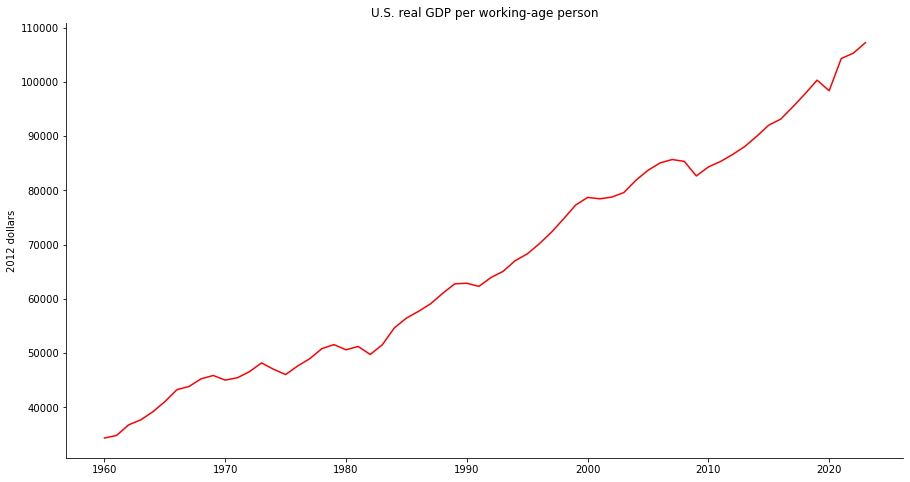

In [5]:
fig, ax = plt.subplots(figsize=myfigsize)

ax.plot(fred.index, fred['gdp_wa'], color='red')

ax.set_ylabel('2012 dollars')
ax.set_title('U.S. real GDP per working-age person')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Adding the last observation notation

When I am working with an api, I sometimes like to keep track of the latest observation, since it can change when I rerun the code in the future. Let's get the last date from our DataFrame.

In [6]:
# First, peel off the last observation's index. Note that this is a DatetimeIndex object.
fred.tail(1).index

DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', name='DATE', freq=None)

In [7]:
# Second, the date attribute of the index gives us an array with the datetime in it. 
fred.tail(1).index.date

array([datetime.date(2023, 1, 1)], dtype=object)

In [8]:
# Third, there is only one observation, so access it using [0].
fred.tail(1).index.date[0]

datetime.date(2023, 1, 1)

Now I have a datetime object. We know what to do with those. Now my figure will automatically update the text with the correct date.

The data is annual, so the year is enough.

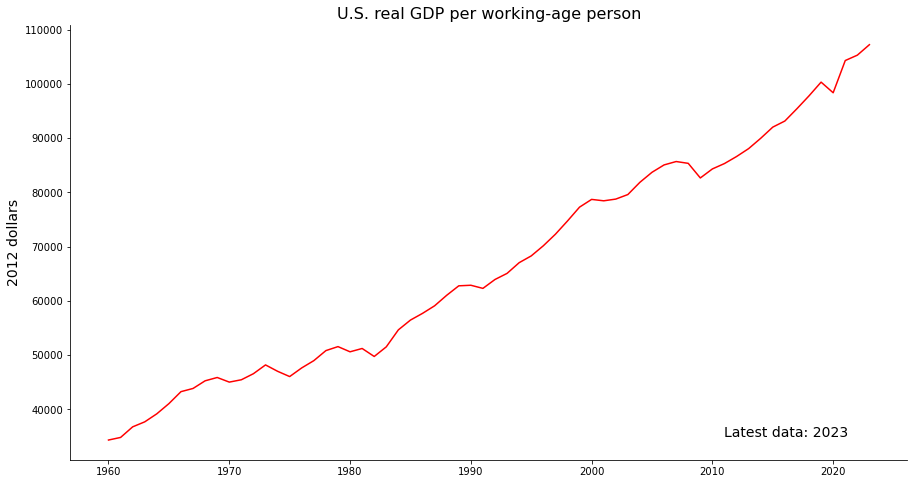

In [9]:
fig, ax = plt.subplots(figsize=myfigsize)

ax.plot(fred.index, fred['gdp_wa'], color='red')

ax.set_ylabel('2012 dollars', fontsize=14)
ax.set_title('U.S. real GDP per working-age person', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(dt.datetime(2011,1,1), 35000, 
        'Latest data: {}'.format(fred.tail(1).index.date[0].strftime('%Y')), fontsize=14)

plt.show()

### World Bank for development indicators

The World Bank provides historical data on a range of development indicators, including poverty and inequality; education, labor, and health; environment; and economies, markets, and trade ([docs](https://pandas-datareader.readthedocs.io/en/latest/readers/world-bank.html)). Let's grab the data for PM2.5 exposure. This is the average exposure to particles <2.5 microns in diameter, which can penetrate into the respiratory tract and cause severe health damage. We'll grab the US and four other randomly-selected countries: Afghanistan, Bosnia and Herzegovina, Cote d'Ivoire, and the Marshall Islands.

In [8]:
from pandas_datareader import wb
pm25 = wb.download(indicator='EN.ATM.PM25.MC.M3',\
                   country=['USA', 'AFG', 'BIH', 'CIV', 'MHL'],\
                   start=1900, end=2020)
pm25.dropna(inplace=True)
print(pm25.head(2), '\n', pm25.tail(2))
# notice the data only go from 1990-2017 in spite of my wider ask
# they're also only quinquennial in the early years. ah, well

                  EN.ATM.PM25.MC.M3
country     year                   
Afghanistan 2019          52.417041
            2018          52.804620 
                     EN.ATM.PM25.MC.M3
country       year                   
United States 1995          12.897703
              1990          13.415680


In [10]:
pm25.unstack('year')    #or pm25.unstack(level = 1)

EN.ATM.PM25.MC.M3                                   \
year                                2019       2018       2017       2016   
country                                                                     
Afghanistan                    52.417041  52.804620  53.355363  57.203704   
Bosnia and Herzegovina         29.466333  29.934485  29.922137  28.775878   
Cote d'Ivoire                  55.623374  55.598218  55.043165  61.246459   
Marshall Islands                9.044040   9.066089   9.153256   9.075501   
United States                   7.663693   7.775115   7.744685   7.378939   

                                                                               \
year                         2015       2014       2013       2012       2011   
country                                                                         
Afghanistan             60.597015  61.865329  58.791659  54.700233  56.247228   
Bosnia and Herzegovina  32.864340  31.605602  32.951174  34.475340  38.145296   
Cote d'Ivoire           63.411079  48.052762  48.791811  56.698226  56.516210   
Marshall Islands         9.019559   9.029031   9.377626   9.279395   9.446099   
United States            8.163753   8.433002   8.641629   8.869988   9.262993   

                                                                               
year                         2010       2005       2000       1995       1990  
country                                                                        
Afghanistan             51.821789  46.151929  51.554534  48.564893  49.282398  
Bosnia and Herzegovina  34.360757  35.955911  38.188874  36.266198  36.723802  
Cote d'Ivoire           50.911102  56.698255  59.883418  48.628901  57.679996  
Marshall Islands         9.715167  10.026995   9.983341   9.362754   9.358540  
United States            9.221852  10.913413  11.945630  12.897703  13.415680

EN.ATM.PM25.MC.M3                                   \
year                                2019       2018       2017       2016   
country                                                                     
Afghanistan                    52.417041  52.804620  53.355363  57.203704   
Bosnia and Herzegovina         29.466333  29.934485  29.922137  28.775878   
Cote d'Ivoire                  55.623374  55.598218  55.043165  61.246459   
Marshall Islands                9.044040   9.066089   9.153256   9.075501   
United States                   7.663693   7.775115   7.744685   7.378939   

                                                                               \
year                         2015       2014       2013       2012       2011   
country                                                                         
Afghanistan             60.597015  61.865329  58.791659  54.700233  56.247228   
Bosnia and Herzegovina  32.864340  31.605602  32.951174  34.475340  38.145296   
Cote d'Ivoire           63.411079  48.052762  48.791811  56.698226  56.516210   
Marshall Islands         9.019559   9.029031   9.377626   9.279395   9.446099   
United States            8.163753   8.433002   8.641629   8.869988   9.262993   

                                                                               
year                         2010       2005       2000       1995       1990  
country                                                                        
Afghanistan             51.821789  46.151929  51.554534  48.564893  49.282398  
Bosnia and Herzegovina  34.360757  35.955911  38.188874  36.266198  36.723802  
Cote d'Ivoire           50.911102  56.698255  59.883418  48.628901  57.679996  
Marshall Islands         9.715167  10.026995   9.983341   9.362754   9.358540  
United States            9.221852  10.913413  11.945630  12.897703  13.415680

You don't need to understand this part yet, but the data comes in with a multi-level index: country, then year. We'll get rid of that, and reshape the data to be "wide" rather than "long," to simplify plotting.

In [4]:
pm25 = pm25.unstack(level=0)       #or pm25 = pm25.unstack('country')
pm25

EN.ATM.PM25.MC.M3
year country                                  
2019 Afghanistan                     52.417041
     Bosnia and Herzegovina          29.466333
     Cote d'Ivoire                   55.623374
     Marshall Islands                 9.044040
     United States                    7.663693
...                                        ...
1990 Afghanistan                     49.282398
     Bosnia and Herzegovina          36.723802
     Cote d'Ivoire                   57.679996
     Marshall Islands                 9.358540
     United States                   13.415680

[70 rows x 1 columns]

Notice that it retained the year index. Excellent. However, we'd like python to know that the index is a datetime object.

Let's also rename the columns using the country [ISO](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) codes from our original API pull. Notice they're in alphabetical order.

Finally, while we're at it, let's sort in ascending order of year.

In [12]:
pm25.index = pd.to_datetime(pm25.index)
pm25.columns = ['AFG', 'BIH', 'CIV', 'MHL', 'USA']
pm25.sort_index(inplace=True)
print(pm25.head(2), '\n', pm25.tail(2))

                  AFG        BIH        CIV       MHL        USA
year                                                            
1990-01-01  49.282398  36.723802  57.679996  9.358540  13.415680
1995-01-01  48.564893  36.266198  48.628901  9.362754  12.897703 
                   AFG        BIH        CIV       MHL       USA
year                                                           
2018-01-01  52.804620  29.934485  55.598218  9.066089  7.775115
2019-01-01  52.417041  29.466333  55.623374  9.044040  7.663693


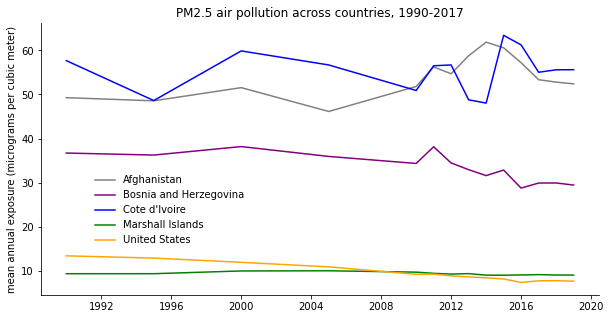

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(pm25.index, pm25['AFG'], color='grey', label='Afghanistan')
ax.plot(pm25.index, pm25['BIH'], color='purple', label='Bosnia and Herzegovina')
ax.plot(pm25.index, pm25['CIV'], color='blue', label="Cote d'Ivoire")
ax.plot(pm25.index, pm25['MHL'], color='green', label='Marshall Islands')
ax.plot(pm25.index, pm25['USA'], color='orange', label='United States')

ax.set_ylabel('mean annual exposure (micrograms per cubic meter)')
ax.set_title('PM2.5 air pollution across countries, 1990-2017')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xticks(['1990', '1995', '2000', '2005', '2010', '2015'])

# Takes some futzing to position the legend so it doesn't crowd the lines
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
#ax.legend(frameon=False)
ax.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.08, 0.15))

plt.show()

## Top Hat Practice Exercise: APIs

Take a few minutes and try the following. Feel free to chat with those around if you get stuck. The TA and I are here, too.

How has inflation in the United States evolved over the last 60 years? Let's investigate.

1. Go the FRED website and find the code for the 'Consumer price index for all urban consumers: All items less food and energy' 
2. Use the api to get the data from 1960 to the most recent. What frequency is the data?

In [13]:
# This is monthly data.
start = dt.datetime(1960, 1, 1)
cpi = web.DataReader('CPILFESL', 'fred', start)
cpi.tail(2)
cpi

,CPILFESL
DATE,
1960-01-01,30.500
1960-02-01,30.600
1960-03-01,30.600
1960-04-01,30.600
1960-05-01,30.600
...,...
2023-10-01,311.390
2023-11-01,312.349
2023-12-01,313.209


3. Create a variable in your DataFrame that holds the growth rate of the CPI&mdash;the inflation rate. Compute it in percentage terms. 

   Remember `.pct_change()`?

In [14]:
cpi['inflation'] = cpi['CPILFESL'].pct_change()*100       #creare new column named inflationin pctchange ased on the previous year
cpi.head()

,CPILFESL,inflation
DATE,,
1960-01-01,30.5,NaN
1960-02-01,30.6,0.327869
1960-03-01,30.6,0.000000
1960-04-01,30.6,0.000000
1960-05-01,30.6,0.000000


4. Plot it. What patterns do you see? 

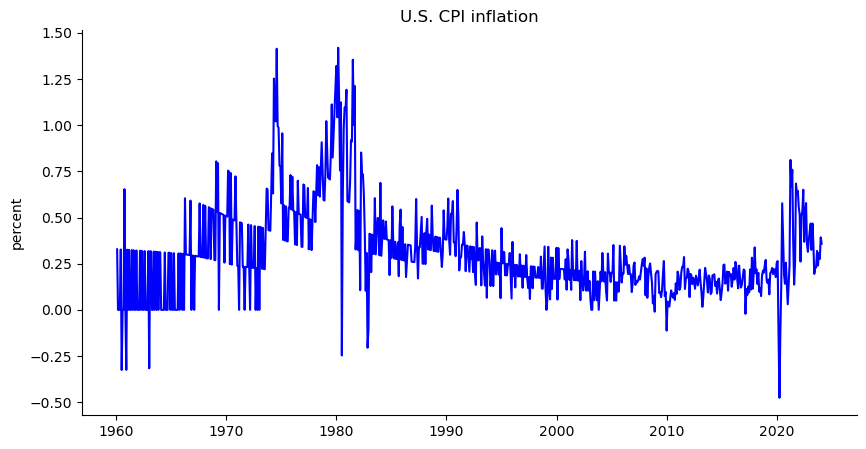

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cpi.index, cpi['inflation'], color='blue')

ax.set_ylabel('percent')
ax.set_title('U.S. CPI inflation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

5. Challenging. We computed the month-to-month inflation rate above. This is not the inflation rate we usually report. Can you compute and plot the year-over-year inflation rate? For example, the inflation rate for 1962-05-01 would be the cpi in 1962-05-01 divided by the cpi in 1961-05-01. 

\[Hint: Check the documentation for `pct_change()`.\]

In [17]:
cpi['infl_year'] = cpi['CPILFESL'].pct_change(periods=12)*100
cpi.tail()

,CPILFESL,inflation,infl_year
DATE,,,
2023-09-01,310.644,0.319064,4.143702
2023-10-01,311.390,0.240146,4.021700
2023-11-01,312.349,0.307974,4.015092
2023-12-01,313.209,0.275333,3.910120
2024-01-01,314.438,0.392390,3.874678


6. Annotate the decrease in inflation around 1983 as 'Volcker disinflation'

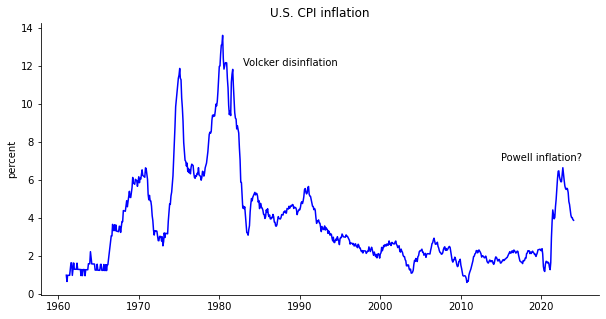

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cpi.index, cpi['infl_year'], color='blue')

ax.set_ylabel('percent')
ax.set_title('U.S. CPI inflation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(dt.datetime(1983, 1,1), 12, 'Volcker disinflation')
ax.text(dt.datetime(2015, 1,1), 7, 'Powell inflation?')

plt.show()

### Stooq for stock prices

Stooq provides historical stock prices ([docs](https://pandas-datareader.readthedocs.io/en/latest/readers/stooq.html)). Let's grab the data for some banks in the wake of Silicon Valley Bank's collapse. We'll try First Foundation and Western Alliance. Note that the data for First Republic Bank, Pacific Western, Silicon Valley Bank, and Credit Suisse are no longer available. h/t to Paul Goldsmith-Pinkham at Yale SOM, who highlighted a similar pattern for some particularly hard-hit banks on [X](https://twitter.com/paulgp/status/1634652494759436291). We'll also include one mega-bank (Bank of America) and Wisconsin's own Associated Bank.

In [19]:
# We'll create an Empty DataFrame object to populate with stock prices
stocks = pd.DataFrame()

# If I do not pass a start or end, it gives the last 5 years. 
start_dt='03-01-2023'

# We'll use a loop to get different stock tickers
# We'll just keep closing prices for simplicity
banks = ['BAC', 'ASB', 'FFWM', 'WAL']
for s in banks:
    data = web.DataReader(s, 'stooq', start=start_dt)
    stocks[s] = data['Close']
stocks.head(10)

,BAC,ASB,FFWM,WAL
Date,,,,
2024-03-01,34.35,20.64,7.63,56.40
2024-02-29,34.52,20.84,7.93,57.73
2024-02-28,34.31,20.64,7.82,57.20
2024-02-27,34.28,20.84,7.89,58.77
2024-02-26,33.61,20.47,7.92,57.80
2024-02-23,33.92,20.63,8.00,58.73
2024-02-22,33.61,20.62,7.88,58.94
2024-02-21,33.70,20.68,7.80,58.41
2024-02-20,33.96,20.78,8.09,60.12


Let's sort by date, normalize by the start date of the series, and plot the trends.

In [20]:
stocks.sort_index(inplace=True)
stocks_norm = stocks/stocks.loc[start_dt]
stocks_norm.head(2)

,BAC,ASB,FFWM,WAL
Date,,,,
2023-03-01,1.000000,1.000000,1.000000,1.000000
2023-03-02,0.980961,0.971662,0.990617,0.984965


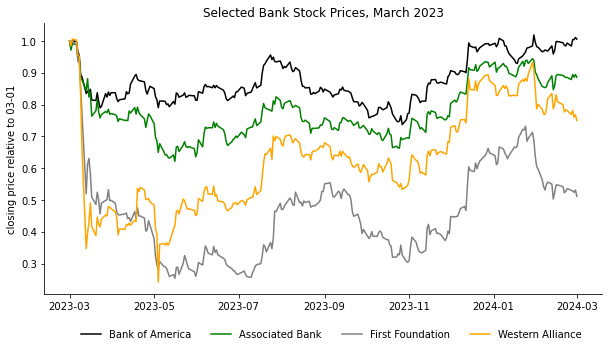

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
['BAC', 'ASB', 'FFWM', 'WAL']
for s, col, lab in zip(banks, 
                  ['black', 'green', 'grey', 'orange'], 
                  ['Bank of America', 'Associated Bank', 
                   'First Foundation', 'Western Alliance']):
    ax.plot(stocks_norm.index, stocks_norm[s], color=col, label=lab)

ax.set_ylabel('closing price relative to 03-01')
ax.set_title('Selected Bank Stock Prices, March 2023')
#plt.xticks(rotation = 45)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.legend(frameon=False)
ax.legend(frameon=False, ncol=4, loc='lower left', bbox_to_anchor=(0.05, -0.2))

plt.show()

## Data without datareader

Some data providers have apis that do not have packages written for them. These apis take a bit more work, including figuring out how to provide the search terms. 

Let's look at the Census Bureau's trade data api. The Census (and many of the national statistical agencies) has an api that takes a bit of work to set up. 

The documentation is [here](https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf).

We are going to retrieve data on the value of U.S. imports of goods, classified by the Harmonized Sytem, from Canada. 

We start with an *endpoint*. Think of it as the address of the server that we want to ask for data (query). Then we build up a string with the requests of the data we need.

In [22]:
# This is the harmonized system endpoint. I learned this from reading the documentation.

base_url = 'https://api.census.gov/data/timeseries/intltrade/imports/hs?'

For this particular api (they are all different...read the docs) we need to specify which variables we want, at what level of disagregation we want the data reported, which countries we want imports from, and from what time period. 

In [23]:
variables = 'GEN_VAL_MO,I_COMMODITY'  # general merchandise value, classification number
level = 'HS10'                        # 10-digit harmonized system classification
country = '1220'                      # Canada
dates = '2020-01'                     # 2021-01

Now we build the url that asks for the data. This is a string. 

* We use `=` to specify the parameters
* We use `&` to add together the different conditional statements

In [24]:
query = base_url + 'get=' + variables + '&COMM_LVL=' + level + '&CTY_CODE=' + country + '&time=' + dates
query

'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,I_COMMODITY&COMM_LVL=HS10&CTY_CODE=1220&time=2020-01'

Copy url (without the quotes) and put it into a web browser. What do you get?

We use the requests package to get the url contents through python ([docs](https://requests.readthedocs.io/en/latest/)). 

In [25]:
import requests
response = requests.get(query)
type(response)

requests.models.Response

The `Response` object has an attribute `.status_code` which we can check. Status codes are list [here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes).

In [26]:
response.status_code

200

Success. 

Okay, now we have the data...how do we get it into a DataFrame? `Response.content` looks promising...

In [27]:
response.content

b'[["GEN_VAL_MO","I_COMMODITY","COMM_LVL","CTY_CODE","time"],\n["66733","9504400000","HS10","1220","2020-01"],\n["342814","9504500000","HS10","1220","2020-01"],\n["41455","9504904000","HS10","1220","2020-01"],\n["195926","9504906000","HS10","1220","2020-01"],\n["2480","9504909040","HS10","1220","2020-01"],\n["43287","9504909060","HS10","1220","2020-01"],\n["23806","9504909080","HS10","1220","2020-01"],\n["5783","9505105020","HS10","1220","2020-01"],\n["14370","9505902000","HS10","1220","2020-01"],\n["23697","9505904000","HS10","1220","2020-01"],\n["754815","9505906000","HS10","1220","2020-01"],\n["3000","9506114010","HS10","1220","2020-01"],\n["79863","9506114080","HS10","1220","2020-01"],\n["63986","9506116000","HS10","1220","2020-01"],\n["11633","9506198080","HS10","1220","2020-01"],\n["467647","9506290080","HS10","1220","2020-01"],\n["2679","9506310000","HS10","1220","2020-01"],\n["643568","9506390080","HS10","1220","2020-01"],\n["2722","9506696020","HS10","1220","2020-01"],\n["6955

That gave us the data formatted for text&mdash;what we saw in the browser. Let's try again.

JSON stands for [JavaScript Object Notation](https://en.wikipedia.org/wiki/JSON) and is a format that is commonly used to store data transmitted on the internet. The `.json()` method of the response object tries to convert the content of the webpage into a standard format. 

In [28]:
data = response.json()
data

[['GEN_VAL_MO', 'I_COMMODITY', 'COMM_LVL', 'CTY_CODE', 'time'],
 ['66733', '9504400000', 'HS10', '1220', '2020-01'],
 ['342814', '9504500000', 'HS10', '1220', '2020-01'],
 ['41455', '9504904000', 'HS10', '1220', '2020-01'],
 ['195926', '9504906000', 'HS10', '1220', '2020-01'],
 ['2480', '9504909040', 'HS10', '1220', '2020-01'],
 ['43287', '9504909060', 'HS10', '1220', '2020-01'],
 ['23806', '9504909080', 'HS10', '1220', '2020-01'],
 ['5783', '9505105020', 'HS10', '1220', '2020-01'],
 ['14370', '9505902000', 'HS10', '1220', '2020-01'],
 ['23697', '9505904000', 'HS10', '1220', '2020-01'],
 ['754815', '9505906000', 'HS10', '1220', '2020-01'],
 ['3000', '9506114010', 'HS10', '1220', '2020-01'],
 ['79863', '9506114080', 'HS10', '1220', '2020-01'],
 ['63986', '9506116000', 'HS10', '1220', '2020-01'],
 ['11633', '9506198080', 'HS10', '1220', '2020-01'],
 ['467647', '9506290080', 'HS10', '1220', '2020-01'],
 ['2679', '9506310000', 'HS10', '1220', '2020-01'],
 ['643568', '9506390080', 'HS10', '

This looks like a nested list. The first sub-list is the column headers. Each following sub-list is a row of data. 

In [29]:
data[0]

['GEN_VAL_MO', 'I_COMMODITY', 'COMM_LVL', 'CTY_CODE', 'time']

In [30]:
data[1]

['66733', '9504400000', 'HS10', '1220', '2020-01']

In [31]:
imports = pd.DataFrame(data[1:], columns=data[0])
imports.head()

,GEN_VAL_MO,I_COMMODITY,COMM_LVL,CTY_CODE,time
0,66733,9504400000,HS10,1220,2020-01
1,342814,9504500000,HS10,1220,2020-01
2,41455,9504904000,HS10,1220,2020-01
3,195926,9504906000,HS10,1220,2020-01
4,2480,9504909040,HS10,1220,2020-01


That took more work than pandas datareader, but wasn't terrible. Now that we know how to use this api, we can easily download exactly what we need in a programmatic way. 

## Top Hat Practice Exercise: APIs on hard mode

Let's try some more downloads from Census. 

1. Try this string in a browser:

```python
'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=2010&time=from+2015-01'
```
   What kind of data is this? What is the unit of observation?


In [32]:
# 1. This is a time series of imports from Mexico at a monthly frequency. 

2. Use `requests.get()` to retrieve the contents of the webpage at the url. 
3. Check the status code, was this successful? 

In [33]:
query = 'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=2010&time=from+2015-01'
response = requests.get(query)
response.status_code

200

4. Use the `.json()` method of the response to turn the data into nested lists. 
5. Turn the nested lists into a DataFrame.
6. Check the dtypes. Make the dates datetime and the GEN_VAL_MO float.  

In [34]:
mexico_json = response.json()
mexico = pd.DataFrame(mexico_json[1:], columns=mexico_json[0])

mexico['time'] = pd.to_datetime(mexico['time'])
mexico.set_index('time', inplace=True)
mexico['GEN_VAL_MO'] = mexico['GEN_VAL_MO'].astype(float)
mexico.head()

,GEN_VAL_MO,CTY_NAME,CTY_CODE
time,,,
2015-01-01,2.226109e+10,MEXICO,2010
2015-02-01,2.270655e+10,MEXICO,2010
2015-03-01,2.565168e+10,MEXICO,2010
2015-04-01,2.470475e+10,MEXICO,2010
2015-05-01,2.448250e+10,MEXICO,2010


7. Plot imports from Mexico with time on the x-axis.  Does anything stand out?

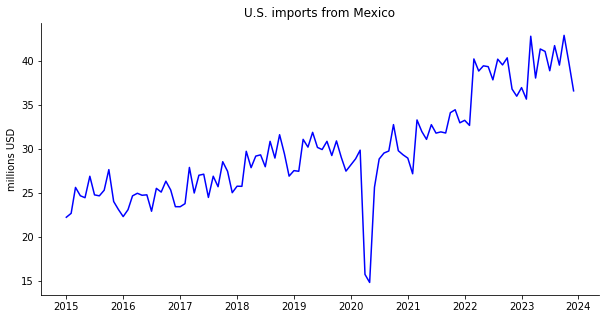

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(mexico.index, mexico['GEN_VAL_MO']/1000000000, color='blue')

ax.set_ylabel('millions USD')
ax.set_title('U.S. imports from Mexico')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

8. Retrieve the content at this url using `requests.get()`. What is the status code?

```python
'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=5070'
```


In [36]:
url = 'https://api.census.gov/data/timeseries/intltrade/imports/hs?get=GEN_VAL_MO,CTY_NAME&CTY_CODE=5070'
response = requests.get(url)
response.status_code

400

9. What does the status code mean? Paste the link into the browser. 
10. Then, try the `.content` attribute of your response object. 

In [37]:
response.content

b'error: error: missing required variable/predicate: time'

# The example below requires an api key

Where you see the code `your_key` is where you should enter your own api key. You need to go to the provider's website and sign up. The examples should work then. 

### Stock prices with iex

According to the [docs](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#morningstar):
>The Investors Exchange (IEX) provides a wide range of data through an API. Historical stock prices are available for up to 5 years.

IEX is one of those companies that requires an api key. These keys can be [pricey](https://iexcloud.io/pricing/) because their target market are business and app developers. They offer a free key, though for experimentation. Very cool of them. 

You can sign up here: [https://iexcloud.io/cloud-login#/register/](https://iexcloud.io/cloud-login#/register/)

In [38]:
# Sometimes you pass your key in the DataReader method. In this case, you save your key as an environmental variable. 
# This means you do not need to keep specifying your key each time you use IEX.

import os
os.environ["IEX_API_KEY"] = 'your_key'

In [39]:
# Harley Davidson prices. The ticker is 'HOG'

start = dt.datetime(2016, 9, 1)
end = dt.datetime(2022, 3, 21)

harley = web.DataReader('HOG', 'iex', start, end)

In [40]:
harley.tail()

,open,high,low,close,volume
date,,,,,
2022-03-15,37.96,38.57,37.6401,38.04,1147738
2022-03-16,38.73,40.32,38.3800,39.44,2000807
2022-03-17,38.96,39.73,38.7200,39.10,1792586
2022-03-18,39.08,40.73,38.5900,40.35,2463025
2022-03-21,40.56,40.87,39.1700,39.44,2781190


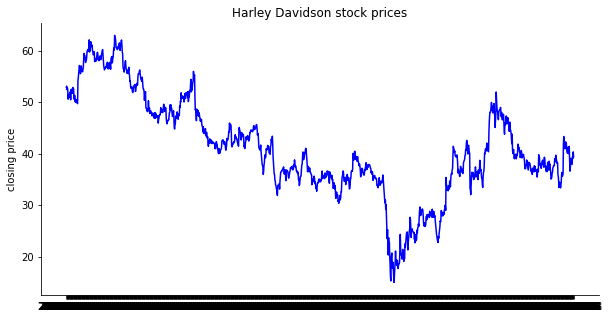

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(harley.index, harley['close'], color='blue')

ax.set_ylabel('closing price')
ax.set_title('Harley Davidson stock prices')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [42]:
# Ahhh! Not a good looking figure.

# We need to set the index to a datetime object so mpl can get the axis right...
# FRED did this for us. 

harley.index = pd.to_datetime(harley.index)

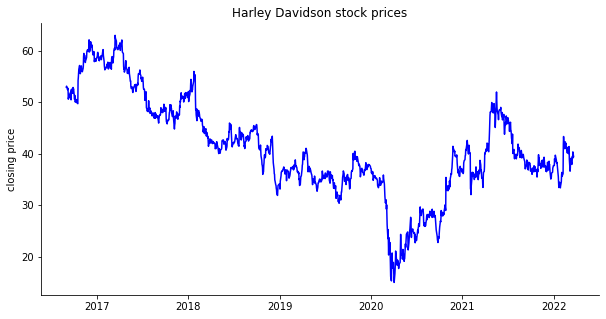

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(harley.index, harley['close'], color='blue')

ax.set_ylabel('closing price')
ax.set_title('Harley Davidson stock prices')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()